## Definitions

In [ ]:
%matplotlib inline
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adadelta, Adam, SGD
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPooling2D, Dropout, Flatten, AveragePooling2D, Conv2DTranspose, UpSampling2D, Rescaling
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy

from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
os.chdir("/content/gdrive/My Drive/Colab Notebooks") # might have to change path to point to your Colab Notebooks folder

Mounted at /content/gdrive


## Load and format data

Number of classes: 10
Example of handwritten digit with correlated noise: 



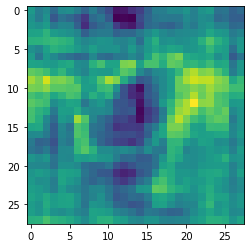

Class: 9

Shape of x_train: (60000, 28, 28, 1)
Shape of y_train: (60000, 10)


In [ ]:
data = np.load('./MNIST_CorrNoise.npz')

x_train = data['x_train']
y_train = data['y_train']

num_cls = len(np.unique(y_train))
print('Number of classes: ' + str(num_cls))

print('Example of handwritten digit with correlated noise: \n')

k = 3000
plt.imshow(np.squeeze(x_train[k,:,:]))
plt.show()
print('Class: '+str(y_train[k])+'\n')

# RESHAPE and standarize
x_train = np.expand_dims(x_train/255,axis=3)

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_cls)

print('Shape of x_train: '+str(x_train.shape))
print('Shape of y_train: '+str(y_train.shape))

## Training

In [ ]:
model_name='CNN' # To compare models, you can give them different names

pweight='./weights/weights_' + model_name  + '.hdf5'

if not os.path.exists('./weights'):
  os.mkdir('./weights')

## EXPLORE VALUES AND FIND A GOOD SET
b_size = 200 # batch size
val_split = 0.75 # percentage of samples used for validation (e.g. 0.5)
ep = 20 # number of epochs

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 28, 28, 1)        3         
 ion)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 14, 14, 128)       18560     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 7, 7, 128)        0         
 g2D)                                                            
                                                     

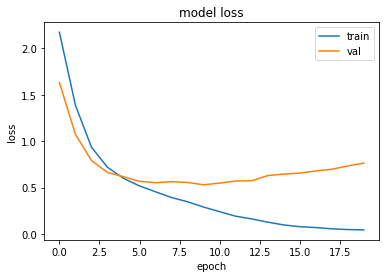

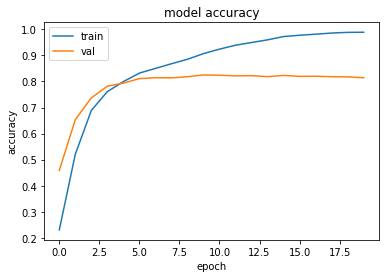

In [ ]:
input_shape = x_train.shape[1:4] #(28,28,1)
#  Sequential()
# from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPooling2D, Dropout, Flatten, AveragePooling2D, Conv2DTranspose, UpSampling2D, Rescaling
import  tensorflow.keras.layers as layers
# second model -- start
model =Sequential([
  layers.Normalization(input_shape=input_shape),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2), strides=(2,2),padding='same',),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2), strides=(2,2),padding='same',),
  # layers.Conv2D(128, 3, padding='same', activation='relu'),
  # layers.MaxPooling2D(pool_size=(2,2), strides=(2,2),padding='same',),
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_cls, activation='softmax')
])
# -- sencond model -- end

## EXPLORE LAYERS, # CHANNELS... Conv2D, Dense, MaxPooling2D, Dropout, Flatten, AveragePooling2D, Conv2DTranspose, UpSampling2D
## SEE KERAS MANUAL https://keras.io/layers/about-keras-layers/

# -- first model -- start
# model.add(Conv2D(1, kernel_size=(3, 3), activation='relu', input_shape=input_shape)) # explore num channels and adding more layers

# model.add(MaxPooling2D(
#     pool_size=(2,2),  # The  down-sampling lattice is 2*2
#     strides=(2,2),  # Step length: down to the right
#     padding='same', # padding mode is 'same'
# ))

# model.add(Conv2D(64, (5, 5), padding='same',activation='relu'))
# # model.add(Dropout(0.5))
# model.add(MaxPooling2D(strides=(2, 2), padding='same'))

# # Make multidimensional inputs one-dimensional
# model.add(Flatten()) # transforms matrix feature map to vector for dense layer (fully connected)
# ##
# model.add(Dense(1024,activation='relu'))  # Full connection layer 1024 points
# model.add(Dropout(0.5))
# model.add(Dense(num_cls, activation='softmax')) # This is a necessary output layer, however, you can add more dense layers before with different activation functions
# -- first model -- end
lr = 0.001
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(learning_rate=lr), # explore other optimizers:Adadelta, Adam, SGD
              metrics=['accuracy'])
model.summary()

checkpointer = ModelCheckpoint(filepath=pweight, verbose=1, save_best_only=True)
callbacks_list = [checkpointer] # explore adding other callbacks such as ReduceLROnPlateau, EarlyStopping

history=model.fit(x_train, y_train,
                        epochs=ep,
                        batch_size=b_size,
                        verbose=1,
                        shuffle=True,
                        validation_split = val_split,
                        callbacks=callbacks_list)

print('CNN weights saved in ' + pweight)

# Plot loss vs epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# for i in history.history:
#   print(i)

# Plot accuracy vs epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Make predictions in test set

In [ ]:
from tensorflow.keras.models import load_model

## LOAD DATA
data = np.load('./MNIST_CorrNoise.npz')

x_test = data['x_test']
y_test = data['y_test']

num_cls = len(np.unique(y_test))
print('Number of classes: ' + str(num_cls))

# RESHAPE and standarize
x_test = np.expand_dims(x_test/255,axis=3)

print('Shape of x_train: '+str(x_test.shape)+'\n')
## Define model parameters
model_name='CNN' # To compare models, you can give them different names
pweight='./weights/weights_' + model_name  + '.hdf5'

model = load_model(pweight)

proba = model.predict(x_test, use_multiprocessing=True)
if proba.shape[-1] > 1:
    y_pred = proba.argmax(axis=-1)
else:
    y_pred = (proba > 0.5).astype('int32')

Acc_pred = sum(y_test == y_pred)/len(y_test)
print('Accuracy in test set is: '+str(Acc_pred))


Number of classes: 10
Shape of x_train: (10000, 28, 28, 1)

Accuracy in test set is: 0.8182
